In [1]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Load Data

In [2]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
test_df_row = test_df.shape[0]
test_df_col = test_df.shape[1]

print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))
print('Testing DataFrame: {} rows & {} columns.'.format(test_df_row, test_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.
Testing DataFrame: 506691 rows & 433 columns.


In [3]:
# release data from those four
del train_transaction
del train_identity
# del test_transaction
# del test_identity

#### Feature Engineering
- Drop rows with more than 90% values missing
- Time
    - Fraud Level (high, mid, low, very low)
    - Minutes to Noon
    - Another column with +- sign
- Transaction Amount:
    - Remove outliers (>30000)
    - Add cent features
- Email Domain:
    - Filter out some very high fraudulent emails
    - Clean some emails
- V
    - Groupby missingness
    - Groupby correlation
    - Keep the column with the most unique values
- UserID
    - Combine card1_d1_addr1
    - Create several means, stds, count aggregations of several features


#### Drop Null Features

In [4]:
def top_missing_cols(df,n=10,thresh=80):
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [5]:
top_missing_cols(train_df, thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [6]:
# top_missing_cols(test_df, thresh=90)

In [7]:
# We can see that columns like id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_01,id_07,id_08 
# have more than 99 percent missing values. Its better we drop those features.
train_df = train_df.drop(columns=['id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26','id_27','id_01','id_07','id_08'])

### Time

In [8]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [9]:
print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

86400


In [10]:
# Fraud Level (high, mid, low, very low)

def fraud_level_time(x):
    very_low = [13,14,15,16]
    low = [12, 17, 22, 0, 1]
    mid = [10, 11, 18, 19, 20, 21, 23, 2, 3]
    high = [4, 5, 6, 7, 8, 9]
    if x in very_low:
        return 'very_low'
    elif x in low:
        return 'low'
    elif x in mid:
        return 'mid'
    else:
        return 'high'

train_df['fraud_level_time'] = train_df['TransactionHour'].apply(fraud_level_time)
# Minutes to Noon
noon = 60 * 60 * 12
train_df['time_to_noon'] = train_df.apply(lambda row: (noon - (row['TransactionDT'] % noon))//60 if (row['TransactionHour'] > 12) else (row['TransactionDT'] % noon)//60, axis=1)
train_df['plus_minus_to_noon'] = train_df['TransactionHour'].apply(lambda x: 'minus' if x < 12 else 'plus')

#### Transaction Amount

In [11]:
# train_df.boxplot(column=['TransactionAmt'])

In [12]:
train_df = train_df[train_df['TransactionAmt'] < 30000]

In [13]:
# train_df.boxplot(column=['TransactionAmt'])

In [14]:
train_df['cents'] = train_df['TransactionAmt'].apply(lambda x: round(x - math.floor(x), 3))
# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#### Email

In [15]:
def email_p(x):
    if x in safe_p_email:
        return 0
    elif x in sus_p_email:
        return 20
    elif x in fraud_p_email:
        return 50
    elif x == 'Missing':
        return -1
    else:
        return 1
    
table_p = pd.pivot_table(train_df, values='TransactionID', index=['P_emaildomain'], columns=['isFraud'], aggfunc='count')
table_p['sum'] = table_p.sum(axis=1)
table_p['0_%'] = table_p[0] / table_p['sum']
table_p['1_%'] = table_p[1] / table_p['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_p[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
#P_emaildomain
safe_p_email = list(table_p[table_p['1_%'].isnull()].index)
sus_p_email = ['aim.com', 'mail.com', 'outlook.es', 'outlook.com']
fraud_p_email = ['protonmail.com']

In [16]:
def email_r(x):
    if x in safe_r_email:
        return 0
    elif x in sus_r_email:
        return 5
    elif x in fraud_r_email:
        return 20
    elif x in death_r_email:
        return 95
    elif x == 'Missing':
        return -1
    else:
        return 1
table_r = pd.pivot_table(train_df, values='TransactionID', index=['R_emaildomain'], columns=['isFraud'], aggfunc='count')
table_r['sum'] = table_r.sum(axis=1)
table_r['0_%'] = table_r[0] / table_r['sum']
table_r['1_%'] = table_r[1] / table_r['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_r[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 
#R_emaildomain
safe_r_email = list(table_r[table_r['1_%'].isnull()].index)
sus_r_email = ['earthlink.net', 'gmail.com', 'hotmail.com', 'hotmail.es', 'icloud.com'] #5
fraud_r_email = ['mail.com', 'netzero.net', 'outlook.com', 'outlook.es'] #20
death_r_email = ['protonmail.com']  #95

In [17]:
train_df['email_p_score'] = train_df['P_emaildomain'].apply(email_p)
train_df['email_r_score'] = train_df['R_emaildomain'].apply(email_r)

#### Address

In [18]:
# train_df['addr2'].astype(str)

In [19]:
table_a2 = pd.pivot_table(train_df, values='TransactionID', index=['addr2'], columns=['isFraud'], aggfunc='count')
table_a2['sum'] = table_a2.sum(axis=1)
table_a2['0_%'] = table_a2[0] / table_a2['sum']
table_a2['1_%'] = table_a2[1] / table_a2['sum']
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_a2[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

table_a2 = table_a2.fillna(0)
a2_df = table_a2[['1_%']]
a2_df['index'] = a2_df.index
addr2_val = list(table_a2.index)
addr2_dict = {}
for i in range(len(addr2_val)):
    addr2_dict[addr2_val[i]] = a2_df.loc[addr2_val[i], '1_%']
addr2_df = train_df[['addr2']].fillna(-2)
train_df['addr2'] = addr2_df['addr2'].copy()
train_df['addr2_score'] = train_df['addr2'].apply(lambda x: -2 if x == -2 else addr2_dict[x])

In [20]:
# train_df[['addr2', 'addr2_score']].head(20)

#### Address 1

In [21]:
table_a1 = pd.pivot_table(train_df, values='TransactionID', index=['addr1'], columns=['isFraud'], aggfunc='count')
table_a1['sum'] = table_a1.sum(axis=1)
table_a1['0_%'] = table_a1[0] / table_a1['sum']
table_a1['1_%'] = table_a1[1] / table_a1['sum']
# fig, ax = plt.subplots(figsize = (12, 100))
# sns.heatmap(table_a1[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [22]:
table_a1 = table_a1.fillna(0)
a1_df = table_a1[['1_%']]
a1_df['index'] = a1_df.index
addr1_val = list(table_a1.index)
addr1_dict = {}
for i in range(len(addr1_val)):
    addr1_dict[addr1_val[i]] = a1_df.loc[addr1_val[i], '1_%']
addr1_df = train_df[['addr1']].fillna(-2)
train_df['addr1'] = addr1_df['addr1'].copy()
train_df['addr1_score'] = train_df['addr1'].apply(lambda x: -2 if x == -2 else addr1_dict[x])

In [23]:
train_df[['addr1', 'addr1_score']].head(2)

,addr1,addr1_score
0,315.0,0.017809
1,325.0,0.025426


#### Device Info

In [24]:
table_di = pd.pivot_table(train_df, values='TransactionID', index=['DeviceInfo'], columns=['isFraud'], aggfunc='count')
table_di['sum'] = table_di.sum(axis=1)
table_di['0_%'] = table_di[0] / table_di['sum']
table_di['1_%'] = table_di[1] / table_di['sum']
# fig, ax = plt.subplots(figsize = (12, 100))
# sns.heatmap(table_di[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [25]:
table_di = table_di.fillna(0)
di_df = table_di[['1_%']]
di_df['index'] = di_df.index
di_val = list(table_di.index)

In [26]:
di_dict = {}
for i in range(len(di_val)):
    di_dict[di_val[i]] = di_df.loc[di_val[i], '1_%']
di_df = train_df[['DeviceInfo']].fillna(-2)
train_df['DeviceInfo'] = di_df['DeviceInfo'].copy()
train_df['DeviceInfo_score'] = train_df['DeviceInfo'].apply(lambda x: di_dict[x] if x in di_dict.keys() else -2)

In [27]:
# train_df[['DeviceInfo', 'DeviceInfo_score']].head(200)

#### V

In [28]:
# Groupby missingness
# Groupby correlation
# Keep the column with the most unique values
v_df = train_df.iloc[:, 85:424]
v_miss_df = pd.DataFrame(v_df.isnull().mean())
v_miss_df['col'] = v_miss_df.index
group_by_miss_perc = {}
miss_perc = list(v_miss_df[0])
miss_col = list(v_miss_df['col'])

for i in range(len(miss_perc)):
    if miss_perc[i] not in group_by_miss_perc.keys():
        group_by_miss_perc[miss_perc[i]] = [v_miss_df['col'][i]]
    else:
        group_by_miss_perc[miss_perc[i]].append(v_miss_df['col'][i])
        
miss_keys = list(group_by_miss_perc.keys())

# group_by_miss_perc
# for i in miss_keys:
#     sub_df = train_df[group_by_miss_perc[i]]
#     corr = sub_df.corr()
#     sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
#     plt.show()

final_col_v = []
for i in range(len(miss_keys)):
    corr = train_df[group_by_miss_perc[miss_keys[i]]].corr()
    group = []
    
    for i in corr.columns:
        sub_group = [i]
        for j in corr.columns:
            if (corr[i][j] > 0.7) and (corr[i][j] < 1):
                sub_group.append(j)
        group.append(sub_group)
    
    for i in group:
        i.sort()
    final_group = []
    
    for i in group:
        if i not in final_group:
            final_group.append(i)
            
    for i in final_group:
        if len(i) != 1:
            temp = {}
            for j in i:
                temp[j] = train_df[j].nunique()
            sorted_temp = sorted(temp.items(), key=lambda item: item[1])
            final_col_v.append(sorted_temp[-1][0])
        else:
            final_col_v.append(i[0])

In [29]:
final_col_v = list(set(final_col_v))

In [30]:
final_col_v.sort()

### Columns


In [31]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour', 'fraud_level_time',
               'plus_minus_to_noon', 'ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log', 'time_to_noon', 'cents', 'TransactionAmt_log',
         'email_p_score', 'email_r_score', 'addr2_score', 'addr1_score', 'DeviceInfo_score']


# num_list = num_list + final_col_v

In [32]:
to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
nums = train_df[num_list].reset_index(drop=True)
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
xxx = X.columns

### Train Test Split

In [33]:
#Raw Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=59054)

### XGBoost Decision Tree - Raw Ratio

In [34]:
#Raw Ratio
def XGBoost_DT(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [35]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train, X_test, y_train, y_test)

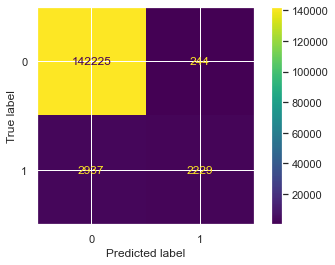

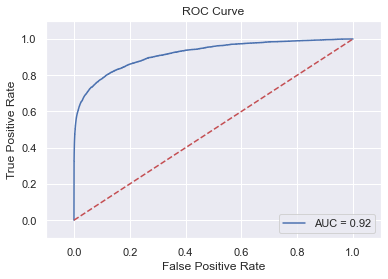

In [36]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [37]:
def XGBoost_DT_T(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier(eta=0.2, eval_metric='rmse', max_depth=9, min_child_weight=0.5,subsample=1)
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [38]:
xgb_cl_T, accuracy_T, X_test_T, y_test_T, y_preds_T, preds_T, fpr_T, tpr_T, auc_score_T = XGBoost_DT_T(X_train, X_test, y_train, y_test)

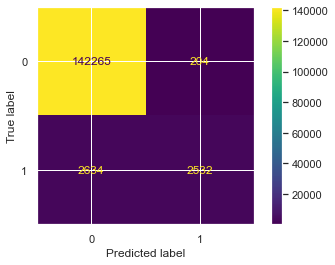

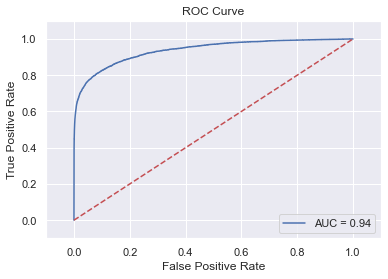

In [39]:
plot_confusion_matrix(xgb_cl_T, X_test_T, y_test_T)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr_T, tpr_T, label='AUC = {:.2f}'.format(auc_score_T))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Preparing Test Set

In [40]:
test_df = test_df.drop(columns=['id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26','id-27','id-01','id-07','id-08'])

In [41]:
#min(train_df['TransactionDT']) #86506

In [42]:
#min(test_df['TransactionDT']) #18404013

#### Time

In [43]:
test_df['TransactionDT'] = test_df['TransactionDT'] - min(train_df['TransactionDT'])
test_df['TransactionDayOfWeek'] = test_df['TransactionDT'].apply(convert_day_of_week)
test_df['TransactionHour'] = test_df['TransactionDT'].apply(convert_hour)
test_df['fraud_level_time'] = test_df['TransactionHour'].apply(fraud_level_time)
test_df['time_to_noon'] = test_df.apply(lambda row: (noon - (row['TransactionDT'] % noon))//60 if (row['TransactionHour'] > 12) else (row['TransactionDT'] % noon)//60, axis=1)
test_df['plus_minus_to_noon'] = test_df['TransactionHour'].apply(lambda x: 'minus' if x < 12 else 'plus')

#### Amount

In [44]:
test_df['cents'] = train_df['TransactionAmt'].apply(lambda x: round(x - math.floor(x), 3))
test_df['TransactionAmt_log'] = test_df['TransactionAmt'].apply(lambda x: np.log(x))

#### Email

In [45]:
test_df['email_p_score'] = test_df['P_emaildomain'].fillna('Missing').apply(email_p)
test_df['email_r_score'] = test_df['R_emaildomain'].fillna('Missing').apply(email_r)

#### Addr

In [46]:
test_df['addr2'] = test_df['addr2'].fillna(-2)
test_df['addr2_score'] = test_df['addr2'].apply(lambda x: addr2_dict[x] if x in addr2_dict else (-2 if x == -2 else -1))

In [47]:
test_df['addr1'] = test_df['addr1'].fillna(-2)
test_df['addr1_score'] = test_df['addr1'].apply(lambda x: addr1_dict[x] if x in addr1_dict else (-2 if x == -2 else -1))

#### DeviceInfo

In [48]:
test_df['DeviceInfo'] = test_df['DeviceInfo'].fillna(-2)
test_df['DeviceInfo_score'] = test_df['DeviceInfo'].apply(lambda x: di_dict[x] if x in di_dict else (-2 if x == -2 else -1))

#### Columns

In [49]:
train_df.columns

Index(['TransactionID', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09',
       'id_10', 'id_11', 'id_12',
       ...
       'fraud_level_time', 'time_to_noon', 'plus_minus_to_noon', 'cents',
       'TransactionAmt_log', 'email_p_score', 'email_r_score', 'addr2_score',
       'addr1_score', 'DeviceInfo_score'],
      dtype='object', length=436)

In [50]:
test_df.columns

Index(['TransactionID', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-09',
       'id-10', 'id-11', 'id-12',
       ...
       'fraud_level_time', 'time_to_noon', 'plus_minus_to_noon', 'cents',
       'TransactionAmt_log', 'email_p_score', 'email_r_score', 'addr2_score',
       'addr1_score', 'DeviceInfo_score'],
      dtype='object', length=435)

In [51]:
test_df.columns = list(train_df.drop(columns=['isFraud']).columns)
ohe_features = ohe.transform(test_df[one_hot_lst])
cates = pd.DataFrame(ohe_features.toarray())
nums_part = test_df[num_list]
X = pd.concat([nums_part, cates], axis=1)
X.columns = [x for x in range(len(X.columns.tolist()))]

In [52]:
preds = xgb_cl.predict(X)
preds_T = xgb_cl_T.predict(X)
test_df['isFraud'] = pd.Series(preds)
test_df['isFraud'] = pd.Series(preds_T)
submission = test_df[['TransactionID', 'isFraud']]
submission_T = test_df[['TransactionID', 'isFraud']]

In [53]:
submission.to_csv("submission_FE_NV.csv", index=False)
submission_T.to_csv("submission_FE_T_NV.csv", index=False)

In [54]:
submission

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
